# The Impact of Demographic Factors on Mortality Due to Cancer
## Preparation of a Regression Model
#### Szymon Abramczyk 325445, Sonia Bogdańska 325449



Demographic and health data for various regions

Data source: https://www.kaggle.com/datasets/varunraskar/cancer-regression

## Table of Contents
1. [Data Preparation](#data)
2. [Feature selection](#selection)
3. [Modeling](#model)
4. [Model Evaluation](#evaluation)

## 1. Data Preparation <a name="data"></a>

In [100]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [101]:
data = pd.read_csv('data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   avganncount             3047 non-null   float64
 1   avgdeathsperyear        3047 non-null   int64  
 2   deathrate               3047 non-null   float64
 3   incidencerate           3047 non-null   float64
 4   medincome               3047 non-null   int64  
 5   popest2015              3047 non-null   int64  
 6   povertypercent          3047 non-null   float64
 7   studypercap             3047 non-null   float64
 8   binnedinc               3047 non-null   object 
 9   medianage               3047 non-null   float64
 10  medianagemale           3047 non-null   float64
 11  medianagefemale         3047 non-null   float64
 12  geography               3047 non-null   object 
 13  percentmarried          3047 non-null   float64
 14  pctnohs18_24            3047 non-null   

In [102]:
data.drop('avgdeathsperyear', inplace=True, axis=1)

The *avgdeathsperyear* feature directly relates to our dependent variable - *deathrate*, so we do not consider it.



In [103]:
features = [
    'avganncount',           # Average number of reported cancer cases diagnosed annually in the county
    'incidencerate',         # Average number of cancer diagnoses per 100,000 residents in the county
    'medincome',             # Average household income in the county
    'popest2015',            # County population in 2015
    'povertypercent',        # Percentage of the county population living below the poverty line
    'studypercap',           # Number of clinical studies related to cancer per capita in the county
    'medianage',             # Average age of county residents
    'medianagemale',         # Average age of men in the county
    'medianagefemale',       # Average age of women in the county
    'percentmarried',        # Percentage of county residents who are married
    'pctnohs18_24',          # Percentage of residents aged 18–24 who did not complete high school
    'pcths18_24',            # Percentage of residents aged 18–24 with a high school education
    'pctbachdeg18_24',       # Percentage of residents aged 18–24 with a bachelor's degree
    'pcths25_over',          # Percentage of residents over 25 years old with a high school education
    'pctbachdeg25_over',     # Percentage of residents over 25 years old with a bachelor's degree
    'pctemployed16_over',    # Percentage of residents over 16 years old who are employed
    'pctunemployed16_over',  # Percentage of residents over 16 years old who are unemployed
    'pctprivatecoverage',    # Percentage of county residents with private health insurance
    'pctempprivcoverage',    # Percentage of county residents with employer-provided private health insurance
    'pctpubliccoverage',     # Percentage of county residents with government-provided health insurance
    'pctpubliccoveragealone',# Percentage of county residents with only public health insurance
    'pctwhite',              # Percentage of county residents identifying as white
    'pctblack',              # Percentage of county residents identifying as black
    'pctasian',              # Percentage of county residents identifying as Asian
    'pctotherrace',          # Percentage of county residents identifying as another race
    'pctmarriedhouseholds',  # Percentage of households in the county where residents are married
    'birthrate'              # Number of live births relative to the number of women in the county
]
target = 'deathrate'

In [104]:
y = data[target]
X = data[features]

### Data Scaling

In [105]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Splitting Data into Training and Test Sets

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=43)

In [107]:
X_train_df = pd.DataFrame(X_train, columns = X.columns)
X_test_df = pd.DataFrame(X_test, columns = X.columns)

## 2. Feature Selection <a name="selection"></a>

We will prepare several feature sets using different approaches to compare these sets and choose the one that achieves the best results.

1. Feature set based on hypothesis
2. Feature set selected using a greedy method
3. Feature set selected using the LASSO method
4. Feature set selected using the SelectKBest method

### 2.1. Feature Set Based on Hypothesis

Recall our hypothesis: An increase in the mortality rate due to malignant tumors is associated with lower average household income, a smaller percentage of people with higher education, a higher percentage of the population living below the poverty line, a higher percentage of unemployed people, and a higher percentage of people using public health insurance.

The dependent variable will be **deathrate**. According to the hypothesis, the explanatory variables can be selected from the following list:
* *medincome*: Average household income in the county.
* *povertypercent*: Percentage of the county population living below the poverty line.
* *pcths25_over*: Percentage of residents over 25 years old with a high school education.
* *pctbachdeg25_over*: Percentage of residents over 25 years old with a bachelor's degree.
* *pctemployed16_over*: Percentage of residents over 16 years old who are employed.
* *pctunemployed16_over*: Percentage of residents over 16 years old who are unemployed.
* *pctempprivcoverage*: Percentage of county residents with employer-provided private health insurance.
* *pctpubliccoverage*: Percentage of county residents with government-provided health insurance.
* *pctpubliccoveragealone*: Percentage of county residents with only public health insurance.


In [108]:
columns_of_interest = [
    'deathrate', 'medincome', 'povertypercent',
    'pcths25_over', 'pctbachdeg25_over', 'pctemployed16_over',
    'pctunemployed16_over',
    'pctempprivcoverage', 'pctpubliccoverage', 'pctpubliccoveragealone'
]
df = data[columns_of_interest]

correlation_matrix = df.corr()

threshold = 0.75
columns_to_remove = set()
for i in correlation_matrix.columns:
    for j in correlation_matrix.columns:
        if i != j and abs(correlation_matrix.loc[i, j]) > threshold:
            columns_to_remove.add( (tuple(sorted((i, j))),  abs(correlation_matrix.loc[i, j])) )


columns_to_remove = pd.DataFrame(columns_to_remove, columns=['pair', 'correlation'])

print("Highly correlated pairs: \n", columns_to_remove.sort_values(by=['correlation'], ascending=False))


Highly correlated pairs: 
                                           pair  correlation
5  (pctpubliccoverage, pctpubliccoveragealone)     0.865833
2     (pctpubliccoveragealone, povertypercent)     0.798642
0                  (medincome, povertypercent)     0.788965
4      (pctempprivcoverage, pctpubliccoverage)     0.778315
3               (medincome, pctpubliccoverage)     0.754822
1      (pctemployed16_over, pctpubliccoverage)     0.751650


Let's look at the correlation matrix:

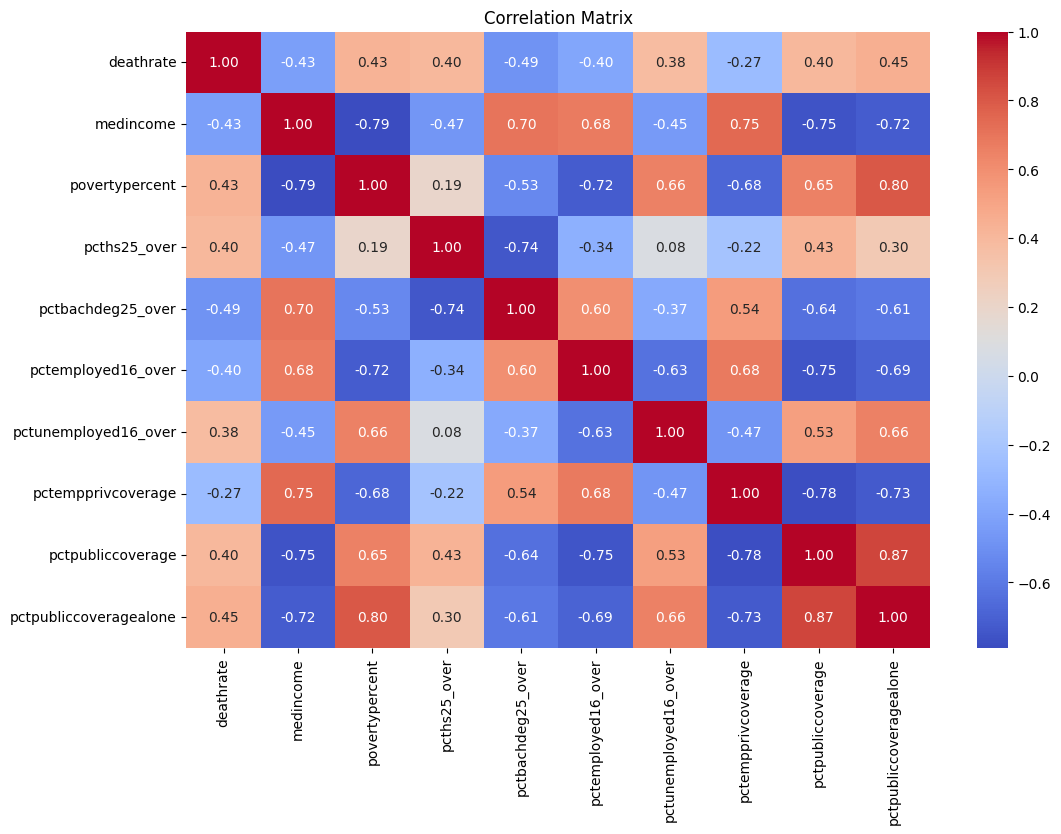

In [109]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [110]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

X_initial = df.drop(columns=['deathrate']) 
vif_data = calculate_vif(X_initial)

death_corr = pd.DataFrame(correlation_matrix['deathrate'])
death_corr = death_corr.reset_index()
vif_data = pd.merge(vif_data, death_corr, left_on='feature', right_on='index')
vif_data.drop(columns=['index'], inplace=True)
print("VIF:\n", vif_data)

VIF:
                   feature         VIF  deathrate
0               medincome   66.676472  -0.428615
1          povertypercent   29.700986   0.429389
2            pcths25_over   65.885679   0.404589
3       pctbachdeg25_over   28.573236  -0.485477
4      pctemployed16_over   96.360368  -0.397433
5    pctunemployed16_over   13.721051   0.378412
6      pctempprivcoverage   68.313120  -0.267399
7       pctpubliccoverage  111.419605   0.404572
8  pctpubliccoveragealone   81.377972   0.449358


The pair of explanatory variables most strongly correlated were pctpubliccoverage and pctpubliccoveragealone. Analyzing the VIF (Variance Inflation Factor) and correlation coefficients with the dependent variable, it is more reasonable to keep pctpubliccoveragealone, as this variable is more strongly correlated with the dependent variable and exhibits less multicollinearity.

In [111]:
correlation_matrix.drop(['pctpubliccoverage'], inplace=True)
correlation_matrix.drop(['pctpubliccoverage'], axis=1, inplace=True)

In [112]:
threshold = 0.75
columns_to_remove = set()
for i in correlation_matrix.columns:
    for j in correlation_matrix.columns:
        if i != j and abs(correlation_matrix.loc[i, j]) > threshold:
            columns_to_remove.add( (tuple(sorted((i, j))),  abs(correlation_matrix.loc[i, j])) )


columns_to_remove = pd.DataFrame(columns_to_remove, columns=['pair', 'correlation'])

print("Highly correlated features: \n", columns_to_remove.sort_values(by=['correlation'], ascending=False))

Highly correlated features: 
                                        pair  correlation
0  (pctpubliccoveragealone, povertypercent)     0.798642
1               (medincome, povertypercent)     0.788965


The other two pairs both contain the variable povertypercent, so let's eliminate it:

In [113]:
correlation_matrix.drop(['povertypercent'], inplace=True)
correlation_matrix.drop(['povertypercent'], axis=1, inplace=True)

In [114]:
X_initial = df.drop(columns=['deathrate', 'pctpubliccoverage', 'povertypercent']) 
vif_data = calculate_vif(X_initial)

death_corr = pd.DataFrame(correlation_matrix['deathrate'])
death_corr = death_corr.reset_index()
vif_data = pd.merge(vif_data, death_corr, left_on='feature', right_on='index')
vif_data.drop(columns=['index'], inplace=True)
print("VIF:\n", vif_data)

VIF:
                   feature        VIF  deathrate
0               medincome  54.820135  -0.428615
1            pcths25_over  39.848992   0.404589
2       pctbachdeg25_over  23.277606  -0.485477
3      pctemployed16_over  95.600552  -0.397433
4    pctunemployed16_over  11.978069   0.378412
5      pctempprivcoverage  62.757044  -0.267399
6  pctpubliccoveragealone  26.666945   0.449358


In [115]:
features_hypothesis = ['medincome', 'pcths25_over', 'pctbachdeg25_over', 'pctemployed16_over', 'pctunemployed16_over', 'pctempprivcoverage', 'pctpubliccoveragealone']

### 2.2. Feature Set Selected Using a Greedy Method

Initially, we attempted feature selection by finding permutations of the feature list that would minimize cross-validation error. Unfortunately, this method proved to be too computationally demanding and, as a result, too time-consuming:

In [116]:
# from sklearn.linear_model import LinearRegression
# from itertools import combinations
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import cross_val_score

# lr = LinearRegression()

# best_scores = []
# best_feature_sets = []

# for num_features in range(1, 11): 
#     best_score = float('inf')
#     best_set = None

#     for combo in combinations(features, num_features):
#         error = -cross_val_score(lr, X_train_df[list(combo)], y_train, cv=5, scoring='neg_mean_squared_error').mean()

#         if error < best_score:
#             best_score = error
#             best_set = combo

#     best_scores.append(best_score)
#     best_feature_sets.append(best_set)
#     print(f"{num_features} cech: {best_set}, błąd: {best_score}")

# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(best_scores) + 1), best_scores, marker='o', linestyle='-')
# plt.xlabel('Number of Features')
# plt.ylabel('Average CV Score')
# plt.title('CV Score')
# plt.grid(True)
# plt.show()

# for i, (score, features_set) in enumerate(zip(best_scores, best_feature_sets), start=1):
#     print(f"{i} Features: {features_set}, CV Score: {score}")

Since the above feature selection method was very time-consuming and, for up to five features, yielded the same results as a greedy method, we decided to select features using a greedy approach.

1 Features: ['pctbachdeg25_over'], CV score: 587.5325477428422
2 Features: ['pctbachdeg25_over', 'incidencerate'], CV score: 440.661730341625
3 Features: ['pctbachdeg25_over', 'incidencerate', 'povertypercent'], CV score: 412.9454526570321
4 Features: ['pctbachdeg25_over', 'incidencerate', 'povertypercent', 'pcths18_24'], CV score: 406.5305942870021
5 Features: ['pctbachdeg25_over', 'incidencerate', 'povertypercent', 'pcths18_24', 'pctotherrace'], CV score: 401.2002426075862
6 Features: ['pctbachdeg25_over', 'incidencerate', 'povertypercent', 'pcths18_24', 'pctotherrace', 'pctmarriedhouseholds'], CV score: 397.3639030524834
7 Features: ['pctbachdeg25_over', 'incidencerate', 'povertypercent', 'pcths18_24', 'pctotherrace', 'pctmarriedhouseholds', 'medianagefemale'], CV score: 394.87268133292406
8 Features: ['pctbachdeg25_over', 'incidencerate', 'povertypercent', 'pcths18_24', 'pctotherrace', 'pctmarriedhouseholds', 'medianagefemale', 'birthrate'], CV score: 391.7202637904012
9 Features: 

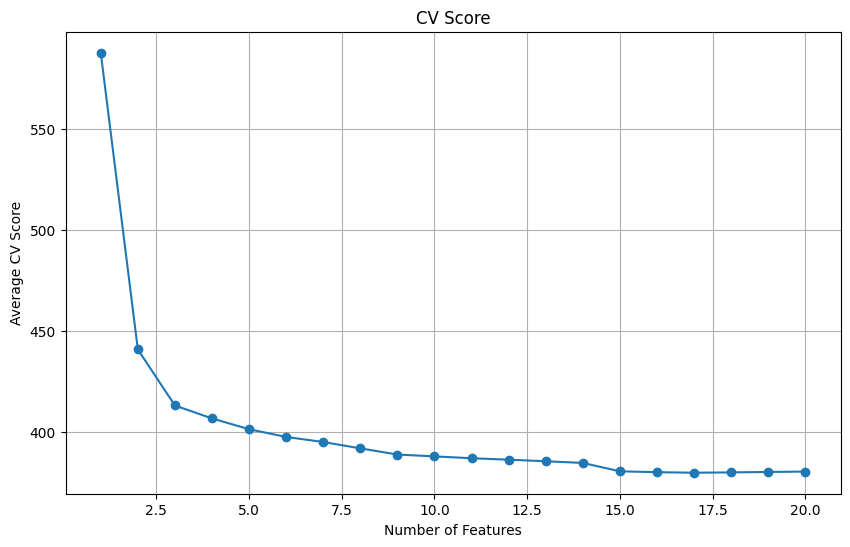

Best number of features: 17


In [117]:
def choose_greedily(current_features, all_features):
    best_score = float('inf')
    best_set = None

    lr = LinearRegression()

    for feat in all_features:
        if feat not in current_features:
            features = current_features + [feat]
            error = -cross_val_score(lr, X_train_df[features], y_train, cv=5, scoring='neg_mean_squared_error').mean()

            if error < best_score:
                best_score = error
                best_set = features


    print(f"{len(best_set)} Features: {best_set}, CV score: {best_score}")
    return best_set, best_score


curr_feat = []
best_scores1 = []
best_feature_sets1 = []

best_n=0
best_score=100000
best_set=[]

for i in range(20):
    curr_feat, score = choose_greedily(curr_feat, features)
    best_feature_sets1.append(curr_feat)
    best_scores1.append(score)
    if best_score > score:
        best_n = i
        best_score=score
        best_set=curr_feat


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_scores1) + 1), best_scores1, marker='o', linestyle='-')
plt.xlabel('Number of Features')
plt.ylabel('Average CV Score')
plt.title('CV Score')
plt.grid(True)
plt.show()

print(f'Best number of features: {best_n + 1}')

In [118]:
features_greedy = ['pctbachdeg25_over', 'incidencerate', 'povertypercent', 'pcths18_24', 'pctotherrace', 'pctmarriedhouseholds', 'medianagefemale', 'birthrate', 'pctpubliccoveragealone', 'pctempprivcoverage', 'pctprivatecoverage', 'pcths25_over', 'pctwhite', 'percentmarried', 'pctemployed16_over', 'avganncount', 'pctnohs18_24']

### 2.3. Feature Set Selected Using the LASSO Method

We tried L1 regularization for feature selection, testing different regularization parameter values to choose the one that best minimizes cross-validation error.

In [119]:
alphas = [0.01, 0.02, 0.04, 0.08] + [0.08 * (2**i) for i in range(1, 7)] + [10]

train_errors = []
val_errors = []
coefs = []

model = Lasso()
param_grid = {'alpha': alphas} 
cv = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
cv.fit(X_train, y_train)

train_errors = -cv.cv_results_['mean_train_score']
val_errors = -cv.cv_results_['mean_test_score']
best_alpha = cv.best_params_['alpha']
best_model = cv.best_estimator_

for lamb in alphas:
    model = Lasso(alpha=lamb)
    model.fit(X_train, y_train)
    coefs.append(model.coef_)


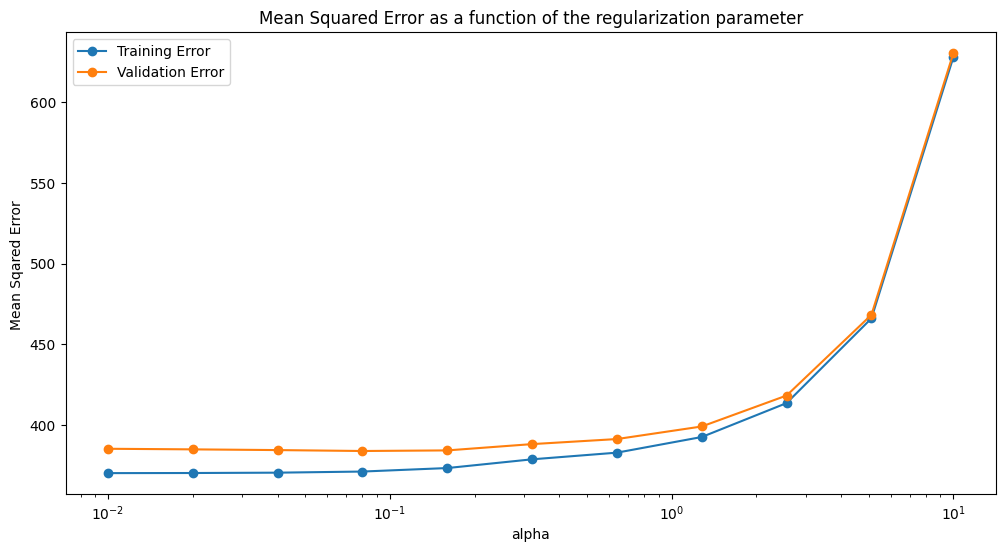

Best alpha value: 0.08


In [120]:

plt.figure(figsize=(12, 6))
plt.plot(alphas, train_errors, label="Training Error", marker='o')
plt.plot(alphas, val_errors, label="Validation Error", marker='o')
plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("Mean Sqared Error ")
plt.title("Mean Squared Error as a function of the regularization parameter")
plt.legend()

plt.show()

print(f"Best alpha value: {best_alpha}")

The best-found value of alpha will be used in training the model in the next step.

### 2.4. Feature Set Selected Using the SelectKBest Method

The SelectKBest method from the scikit-learn package allows us to examine the significance of features using the F-test.

Selected Features: ['avganncount' 'incidencerate' 'medincome' 'povertypercent'
 'percentmarried' 'pcths18_24' 'pctbachdeg18_24' 'pcths25_over'
 'pctbachdeg25_over' 'pctemployed16_over' 'pctunemployed16_over'
 'pctprivatecoverage' 'pctempprivcoverage' 'pctpubliccoverage'
 'pctpubliccoveragealone' 'pctwhite' 'pctblack' 'pctasian' 'pctotherrace'
 'pctmarriedhouseholds']


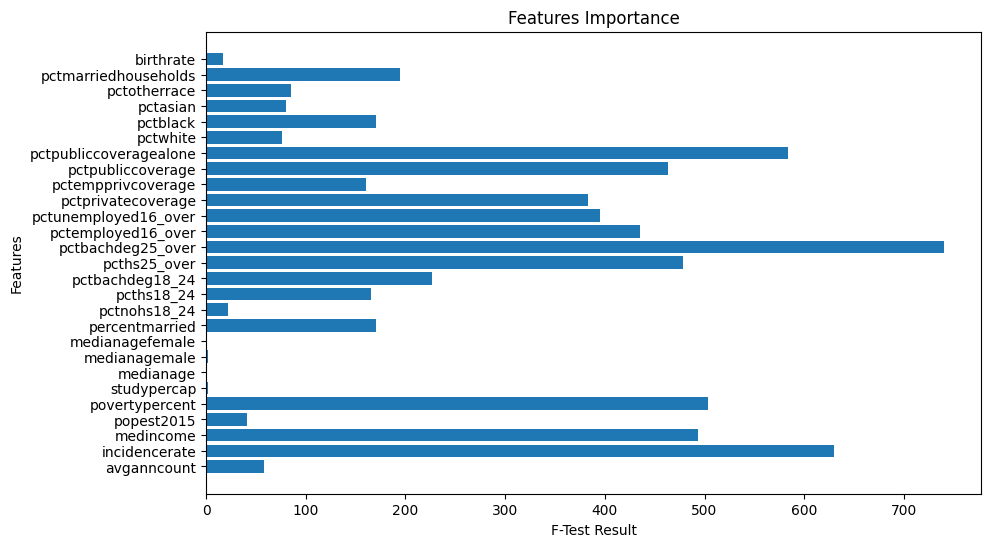

In [121]:
k = 20
selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features = np.array(X.columns)[selector.get_support()]
print("Selected Features:", selected_features)

scores = selector.scores_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, scores)
plt.xlabel("F-Test Result")
plt.ylabel("Features")
plt.title("Features Importance")
plt.show()

In [122]:
features_kbest = ['avganncount', 'incidencerate', 'medincome', 'povertypercent',
 'percentmarried', 'pcths18_24', 'pctbachdeg18_24', 'pcths25_over',
 'pctbachdeg25_over', 'pctemployed16_over', 'pctunemployed16_over',
 'pctprivatecoverage', 'pctempprivcoverage', 'pctpubliccoverage',
 'pctpubliccoveragealone', 'pctwhite', 'pctblack', 'pctasian', 'pctotherrace',
 'pctmarriedhouseholds']

## **3. Modeling <a name="model"></a>**

We will test different models with different feature sets. To facilitate model comparison, we will calculate cross-validation errors for each model and record them to ultimately select the best model.

In [123]:
results = []

We prepared a function that calculates the average cross-validation error for a given model and training data. Cross-validation is performed with five splits.

In [124]:
def cv_score(model, X, y):
    
    k_folds = KFold(n_splits = 5)

    scores = cross_val_score(model, X, y, cv = k_folds)

    print("Cross Validation Scores: ", scores)
    print("Average CV Score: ", scores.mean())
    
    return scores.mean()

### **3.1. Linear Regression**

#### **3.1.1 Linear Regression Model Using Features from the Hypothesis**

In [125]:
X_train_hypothesis = X_train_df[features_hypothesis]
model = LinearRegression()

score = cv_score(model, X_train_hypothesis, y_train)
results.append({
    "Feature_Set": 'features_hypothesis',
    "Average CV Score": score
})

Cross Validation Scores:  [0.26015981 0.32496942 0.36812667 0.34397617 0.32564394]
Average CV Score:  0.3245752016701477


#### **3.1.2 Linear Regression Model Using Features from the Hypothesis and Ridge Regularization**

Due to high multicollinearity, we decided to use L2 regularization (Ridge), which penalizes large regression coefficients, thereby reducing their variance.

To perform Ridge regularization, we find the best value of the alpha parameter using cross-validation. Since we will repeat this for LASSO regularization as well, we created a function for this purpose:

In [126]:
def choose_best_alpha(model, X, y, alphas):
    train_errors = []
    val_errors = []
    coefs = []

    param_grid = {'alpha': alphas} 
    cv = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    cv.fit(X, y)

    train_errors = -cv.cv_results_['mean_train_score']
    val_errors = -cv.cv_results_['mean_test_score']
    best_alpha = cv.best_params_['alpha']
    best_model = cv.best_estimator_

    plt.figure(figsize=(12, 6))
    plt.plot(alphas, train_errors, label="Training Error", marker='o')
    plt.plot(alphas, val_errors, label="Validation Error", marker='o')
    plt.xscale('log')
    plt.xlabel("alpha")
    plt.ylabel("Mean Sqared Error ")
    plt.title("Mean Squared Error as a function of the regularization parameter")
    plt.legend()

    plt.show()

    print(f"Best alpha value:: {best_alpha}")


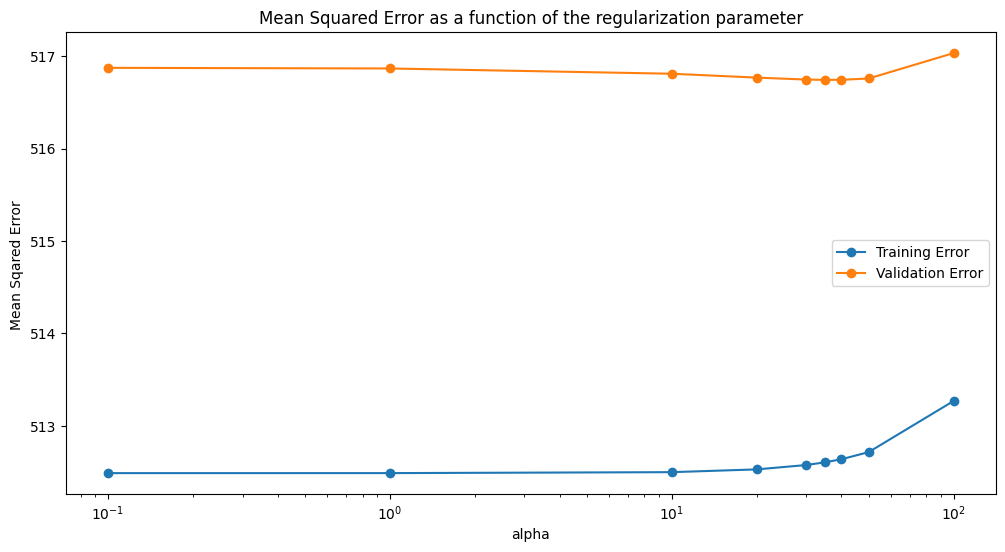

Best alpha value:: 35


In [127]:
alphas = [0.1, 1, 10, 20, 30, 35, 40, 50, 100]

model = Ridge()
choose_best_alpha(model, X_train_hypothesis, y_train, alphas)

In [128]:
X_train_hypothesis = X_train_df[features_hypothesis]
model = Ridge(alpha=35)

score = cv_score(model, X_train_hypothesis, y_train)
results.append({
    "Feature_Set": 'features_hypothesis_ridge',
    "Average CV Score": score
})

Cross Validation Scores:  [0.26307251 0.32550734 0.36649386 0.34303792 0.3252394 ]
Average CV Score:  0.32467020289122145


As can be seen, Ridge regularization did not help much; the cross-validation result is slightly higher.

#### **3.1.3. Linear Regression Model Using Features Selected Greedily**

In [129]:
X_train_greedy = X_train_df[features_greedy]
model = LinearRegression()

score = cv_score(model, X_train_greedy, y_train)
results.append({
    "Feature_Set": 'features_greedy',
    "Average CV Score": score
})

Cross Validation Scores:  [0.49664977 0.47425814 0.52355469 0.48218705 0.53631965]
Average CV Score:  0.5025938594001895


As can be seen, the greedy selection of features from all available features yielded significantly better cross-validation results.

#### **3.1.4. Linear Regression Model Using Features Selected with the KBest Library**


In [130]:
X_train_kbest = X_train_df[features_kbest]
model = LinearRegression()

score = cv_score(model, X_train_kbest, y_train)
results.append({
    "Feature_Set": 'features_kbest',
    "Average CV Score": score
})

Cross Validation Scores:  [0.48694627 0.46651991 0.50911522 0.48263333 0.5212549 ]
Average CV Score:  0.49329392573410863


#### **3.1.5. Linear Regression Model Using LASSO Regularization (All Features)**

We will use the previously selected regularization coefficient for model training:

In [131]:
X_train_lasso = X_train_df[features]
model = Lasso(alpha=0.08)

score = cv_score(model, X_train_lasso, y_train)
results.append({
    "Feature_Set": 'features_lasso',
    "Average CV Score": score
})

Cross Validation Scores:  [0.4893057  0.46557484 0.52385965 0.47637903 0.53022696]
Average CV Score:  0.4970692376995472


#### **3.1.6. Linear Regression Model Using Ridge Regularization (All Features)**

We also checked the model with all features and L2 regularization, which helps reduce the impact of dependencies between explanatory features.

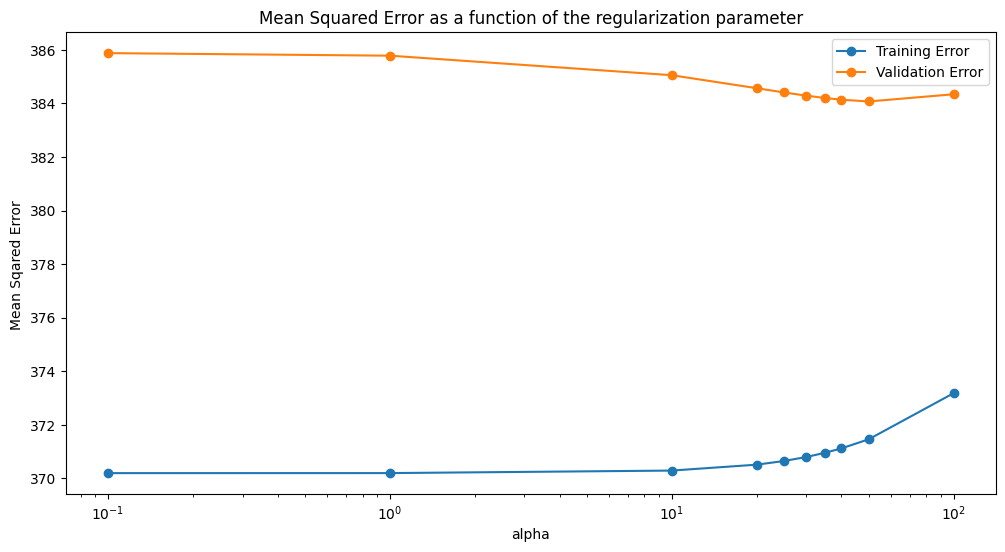

Best alpha value:: 50


In [132]:
alphas = [0.1, 1, 10, 20, 25, 30, 35, 40, 50, 100]

model = Ridge()
choose_best_alpha(model, X_train, y_train, alphas)

In [133]:
X_train_ridge = X_train_df[features]
model = Ridge(alpha=50)

score = cv_score(model, X_train_ridge, y_train)
results.append({
    "Feature_Set": 'features_ridge',
    "Average CV Score": score
})

Cross Validation Scores:  [0.48915954 0.46284553 0.5252479  0.47728062 0.53007005]
Average CV Score:  0.49692072673453397


#### **3.1.7. Linear Regression Model Using Elastic Net Regularization (All Features)**

We checked how Elastic Net, a combination of L1 and L2 regularization, performs:

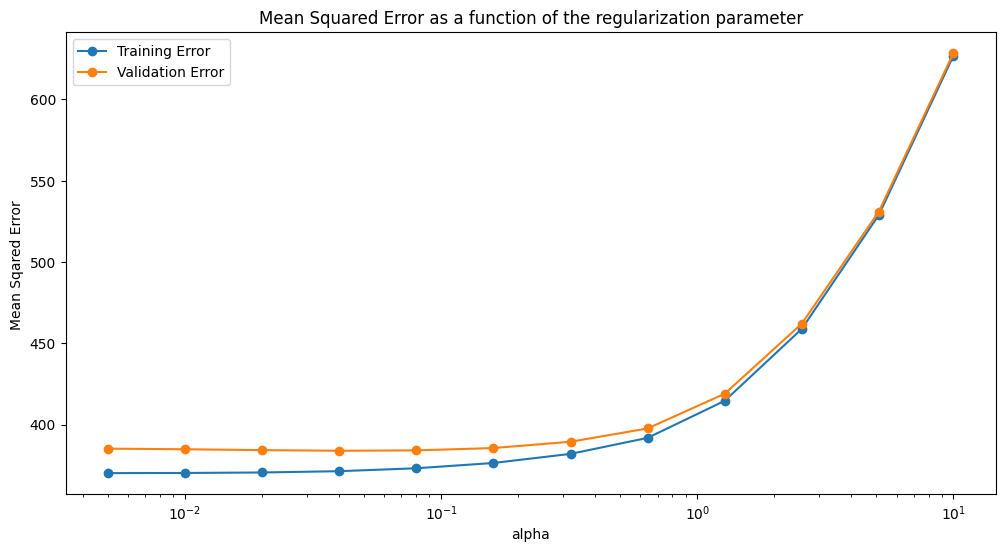

Best alpha value:: 0.04


In [134]:
alphas = [0.005, 0.01, 0.02, 0.04, 0.08] + [0.08 * (2**i) for i in range(1, 7)] + [10]

model = ElasticNet()
choose_best_alpha(model, X_train, y_train, alphas)

In [135]:
X_train_EN = X_train_df[features]
model = ElasticNet(alpha=0.04)

score = cv_score(model, X_train_EN, y_train)
results.append({
    "Feature_Set": 'features_EN',
    "Average CV Score": score
})

Cross Validation Scores:  [0.48914546 0.46353773 0.52505899 0.4770793  0.53027157]
Average CV Score:  0.4970186096561101


### **3.2. Polynomial Regression**

Although our analysis suggested that the relationships between individual features and the dependent variable were linear, we also tested polynomial regression models, as not all relationships can be discerned from plots.

In [136]:
degrees = [1, 2, 3, 4, 5] 

In [137]:
for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train_df[features_hypothesis])
    
    model = LinearRegression()
    
    scores = -cross_val_score(model, X_poly_train, y_train, scoring='neg_mean_squared_error', cv=5)
    print(f'CV score for degree {degree}: ' + str(scores.mean()))


CV score for degree 1: 516.8760585345024
CV score for degree 2: 495.4145516231396
CV score for degree 3: 533.1851643084577
CV score for degree 4: 1508.0068880940985
CV score for degree 5: 56872.08548122033


It can be observed that polynomial regression of degree 2 achieves better results than degree 1 (linear). For this reason, we will also test polynomial regression models with a second-degree polynomial.

#### **3.2.1. Polynomial Regression Model Using Features from the Hypothesis**

In [138]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_df[features_hypothesis])
model = LinearRegression()

score = cv_score(model, X_train_poly, y_train)
results.append({
    "Feature_Set": 'features_poly_hypothesis',
    "Average CV Score": score
})

Cross Validation Scores:  [0.29257649 0.34922237 0.38733154 0.37470756 0.35946009]
Average CV Score:  0.3526596082026853


#### **3.2.2. Polynomial Regression Model Using Features Selected with the KBest Library**


In [139]:
poly = PolynomialFeatures(degree=2)
X_train_poly_kbest = poly.fit_transform(X_train_df[features_kbest])
model = LinearRegression()

score = cv_score(model, X_train_poly_kbest, y_train)
results.append({
    "Feature_Set": 'features_poly_kbest',
    "Average CV Score": score
})

Cross Validation Scores:  [0.40606999 0.35031459 0.4830861  0.42033195 0.36001755]
Average CV Score:  0.4039640382708812


#### **3.2.3. Polynomial Regression Model Using LASSO Regularization (All Features)**

For polynomial regression, we define a similar function for selecting the best regularization coefficient as in the case of linear regression:

In [140]:
def choose_best_alpha_poly(model, X, y, alphas, name):
    train_errors = []
    val_errors = []
    coefs = []

    param_grid = {f'{name}__alpha': alphas} 
    cv = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    cv.fit(X, y)

    train_errors = -cv.cv_results_['mean_train_score']
    val_errors = -cv.cv_results_['mean_test_score']
    best_alpha = cv.best_params_[f'{name}__alpha']
    best_model = cv.best_estimator_

    plt.figure(figsize=(12, 6))
    plt.plot(alphas, train_errors, label="Training Error", marker='o')
    plt.plot(alphas, val_errors, label="Validation Error", marker='o')
    plt.xscale('log')
    plt.xlabel("alpha")
    plt.ylabel("Mean Sqared Error ")
    plt.title("Mean Squared Error as a function of the regularization parameter")
    plt.legend()

    plt.show()

    print(f"Best alpha value:: {best_alpha}")

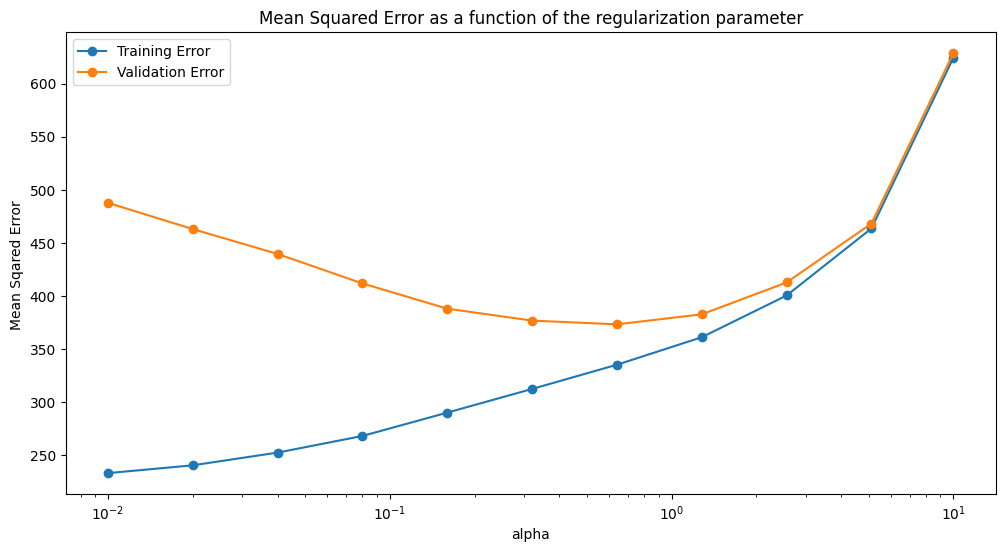

Best alpha value:: 0.64


In [141]:
alphas = [0.01, 0.02, 0.04, 0.08] + [0.08 * (2**i) for i in range(1, 7)] + [10]

X_train_poly_lasso = X_train_df[features]

model = make_pipeline(PolynomialFeatures(degree=2), Lasso(max_iter=15000))
choose_best_alpha_poly(model, X_train_df[features], y_train, alphas, 'lasso')

In [142]:
model = make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=0.64))

score = cv_score(model, X_train_poly_lasso, y_train)
results.append({
    "Feature_Set": 'features_poly_lasso',
    "Average CV Score": score
})

Cross Validation Scores:  [0.49929481 0.48682433 0.54106968 0.50606064 0.52301538]
Average CV Score:  0.5112529672495555


#### **3.2.4. Polynomial Regression Model Using Ridge Regularization (All Features)**

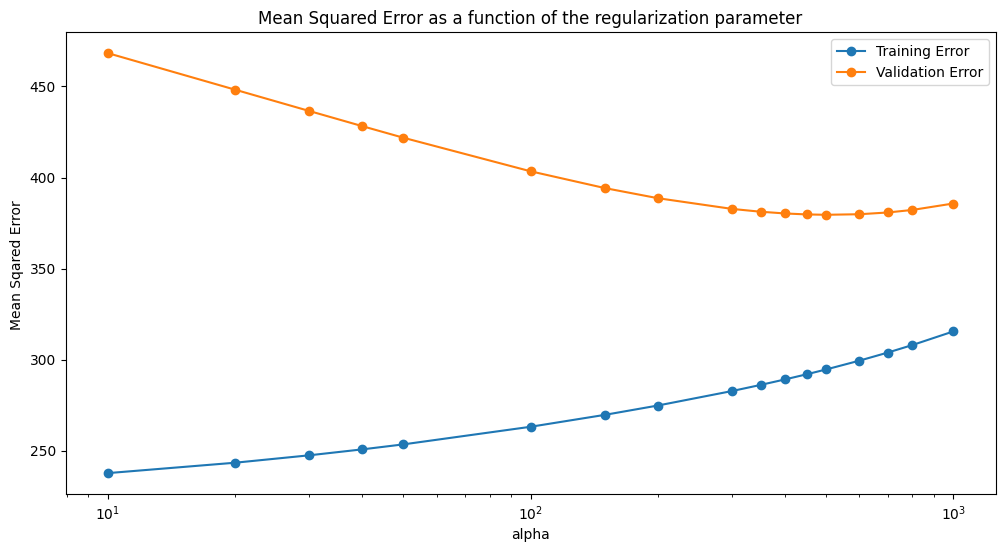

Best alpha value:: 500


In [143]:
alphas = [10, 20, 30, 40, 50, 100, 150, 200, 300, 350, 400, 450, 500, 600, 700, 800, 1000]

X_train_poly_ridge = X_train_df[features]

model = make_pipeline(PolynomialFeatures(degree=2), Ridge())
choose_best_alpha_poly(model, X_train_poly_ridge, y_train, alphas, 'ridge')

In [144]:
model = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=400))

score = cv_score(model, X_train_poly_ridge, y_train)
results.append({
    "Feature_Set": 'features_poly_ridge',
    "Average CV Score": score
})

Cross Validation Scores:  [0.50707857 0.46541633 0.54157418 0.483057   0.51172074]
Average CV Score:  0.5017693650497375


#### **3.2.5 Polynomial Regression Model Using Elastic Net Regularization (All Features)**

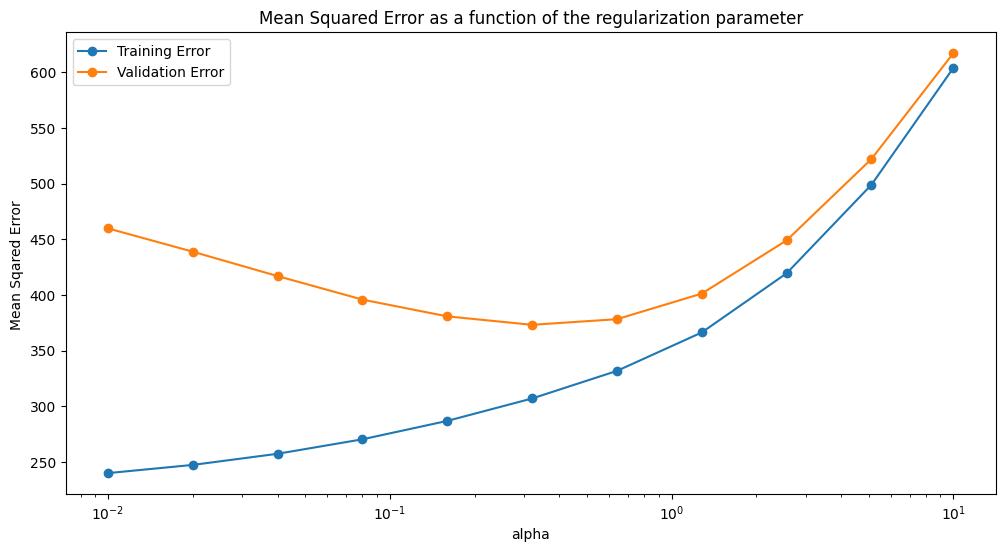

Best alpha value:: 0.32


In [145]:
alphas = [0.01, 0.02, 0.04, 0.08] + [0.08 * (2**i) for i in range(1, 7)] + [10]

X_train_poly_EN = X_train_df[features]

model = make_pipeline(PolynomialFeatures(degree=2), ElasticNet(max_iter=15000))
choose_best_alpha_poly(model, X_train_poly_EN, y_train, alphas, 'elasticnet')

In [146]:
model = make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=0.32))

score = cv_score(model, X_train_poly_EN, y_train)
results.append({
    "Feature_Set": 'features_poly_EN',
    "Average CV Score": score
})

Cross Validation Scores:  [0.50731824 0.47443888 0.54434125 0.5016657  0.52913543]
Average CV Score:  0.5113798992268662


### **3.3. Comparison of Results**

Finally, we display the results of all the models we tested:

In [147]:
results_df = pd.DataFrame(results)
results_df.sort_values(by='Average CV Score', ascending=False)

,Feature_Set,Average CV Score
11,features_poly_EN,0.511380
9,features_poly_lasso,0.511253
2,features_greedy,0.502594
10,features_poly_ridge,0.501769
4,features_lasso,0.497069
6,features_EN,0.497019
5,features_ridge,0.496921
3,features_kbest,0.493294
8,features_poly_kbest,0.403964
7,features_poly_hypothesis,0.352660


Polynomial Regression with Elastic Net had the highest CV score.

## **4. Model Evaluation <a name="evaluation"></a>**

To select the best regression model, we will make predictions for the two best polynomial regression and linear regression models to compare the errors of quality metrics.


In [148]:
def show_results(model, X_test, y_test):
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    }

    print("\n".join("{}\t\t{}".format(k, v) for k, v in results.items()))

In [149]:
def show_feature_importance_poly(model, model_name, features):
    used_model = model.named_steps[model_name]
    feature_names = model.named_steps['polynomialfeatures'].get_feature_names_out(input_features=features)
    coefficients = used_model.coef_

    feature_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": coefficients
    })

    feature_importance = feature_importance.reindex(
    feature_importance.Importance.abs().sort_values(ascending=False).index
    )

    print(feature_importance)


In [150]:
def show_feature_importance_linear(model, features):
    coefficients = model.coef_ 

    feature_importance = pd.DataFrame({
        'Feature': features,
        'Coefficient': coefficients
    })

    feature_importance = feature_importance.sort_values(by='Coefficient', key=np.abs, ascending=False)

    print(feature_importance)

Polynomial regression of degree 2 with ElasticNet:

In [151]:
model1 = make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=0.32))
model1.fit(X_train, y_train)
show_results(model1, X_test, y_test)

MSE		346.5794491024443
RMSE		18.61664441037762
MAE		13.771897475286963
R2		0.5618744337822124


In [152]:
show_feature_importance_poly(model1, 'elasticnet', features)

                              Feature  Importance
2                       incidencerate    7.726300
15                  pctbachdeg25_over   -3.912146
14                       pcths25_over    3.098807
26               pctmarriedhouseholds   -1.861525
25                       pctotherrace   -1.741876
..                                ...         ...
174             studypercap birthrate    0.000000
173  studypercap pctmarriedhouseholds    0.000000
172          studypercap pctotherrace   -0.000000
171              studypercap pctasian   -0.000000
203   medianagemale pctbachdeg25_over   -0.000000

[406 rows x 2 columns]


Polynomial regression of degree 2 with ElasticNet:

In [153]:
model2 = make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=0.64))
model2.fit(X_train, y_train)
show_results(model2, X_test, y_test)

MSE		365.7573073389452
RMSE		19.124782543572756
MAE		14.187546985967039
R2		0.5376309016845321


In [154]:
show_feature_importance_poly(model2, 'lasso', features)

                                   Feature  Importance
2                            incidencerate    9.359032
15                       pctbachdeg25_over   -6.872002
14                            pcths25_over    2.502624
5                           povertypercent    2.474738
26                    pctmarriedhouseholds   -1.889575
..                                     ...         ...
147                povertypercent pctwhite    0.000000
146  povertypercent pctpubliccoveragealone    0.000000
144      povertypercent pctempprivcoverage   -0.000000
143      povertypercent pctprivatecoverage    0.000000
203        medianagemale pctbachdeg25_over    0.000000

[406 rows x 2 columns]


Linear regression with greedily selected features:

In [155]:
model3 = LinearRegression()
model3.fit(X_train_df[features_greedy], y_train)
show_results(model3,  X_test_df[features_greedy], y_test)

MSE		371.51490860690495
RMSE		19.27472201114467
MAE		14.383054655238602
R2		0.5303524772940673


In [156]:
show_feature_importance_linear(model3, features_greedy)
print("Zero coefficients:")
for feature in features:
    if feature not in features_greedy:
        print(feature)

                   Feature  Coefficient
1            incidencerate    10.587369
13          percentmarried     6.858858
5     pctmarriedhouseholds    -6.680001
0        pctbachdeg25_over    -6.261713
10      pctprivatecoverage    -5.054684
9       pctempprivcoverage     4.928427
14      pctemployed16_over    -4.504978
6          medianagefemale    -3.490128
4             pctotherrace    -2.813209
11            pcths25_over     2.413800
12                pctwhite    -2.342949
3               pcths18_24     2.047230
8   pctpubliccoveragealone     2.025212
7                birthrate    -1.631209
15             avganncount    -1.307704
16            pctnohs18_24    -0.932915
2           povertypercent     0.619384
Zero coefficients:
medincome
popest2015
studypercap
medianage
medianagemale
pctbachdeg18_24
pctunemployed16_over
pctpubliccoverage
pctblack
pctasian


Linear regression with LASSO:

In [157]:
model4 = Lasso(alpha=0.08)
model4.fit(X_train, y_train)
show_results(model4, X_test, y_test)

MSE		371.7302313106147
RMSE		19.280306826153332
MAE		14.41280117590512
R2		0.5300802788653182


In [158]:
show_feature_importance_linear(model4, features)

                   Feature  Coefficient
1            incidencerate    10.534757
14       pctbachdeg25_over    -6.236012
25    pctmarriedhouseholds    -5.439950
9           percentmarried     5.219905
17      pctprivatecoverage    -4.126465
18      pctempprivcoverage     3.745932
15      pctemployed16_over    -3.302323
24            pctotherrace    -2.690089
13            pcths25_over     2.517199
20  pctpubliccoveragealone     2.074768
11              pcths18_24     2.053149
21                pctwhite    -1.786314
26               birthrate    -1.568977
7            medianagemale    -1.539534
8          medianagefemale    -1.527911
0              avganncount    -1.401115
10            pctnohs18_24    -0.768490
4           povertypercent     0.755167
16    pctunemployed16_over     0.727620
3               popest2015     0.256380
6                medianage    -0.140004
2                medincome     0.091275
12         pctbachdeg18_24    -0.064544
5              studypercap    -0.003493


##### **The best model turned out to be a 2nd-degree polynomial regression model using ElasticNet.**

The polynomial regression model with ElasticNet proved to be the best because it effectively captured the nonlinear relationships between the features and the target variable, which improved the model's fit. Additionally, ElasticNet provides good generalization by combining Lasso and Ridge and applies appropriate regularization for the complex set of polynomial features.

### **4.2. Conclusions**

#### **Polynomial Regression Model with Elastic Net**
- The coefficients indicate the importance of features such as `incidencerate`, `pctbachdeg25_over` (negative impact), and `pcths25_over`.
Elastic Net combines Lasso and Ridge Regression, allowing for a balance between feature selection and regularization. The most important features are `incidencerate`, `pctbachdeg25_over`, and `pcths25_over`, as well as `povertypercent` and `pctpubliccoveragealone`.

#### **Polynomial Regression Model with LASSO**
- The results are similar to those of the Lasso model with ElasticNet.
`pctmarriedhouseholds` also has a significant impact. The polynomial degree of the model allows for capturing nonlinear relationships, which may explain the higher R² score compared to linear regression.

#### **Linear Regression Model with Greedily Selected Features**
- The model explains 53% of the variance, which is slightly worse than the results of the polynomial models. The selected linear features have the greatest impact on the outcome, e.g., `incidencerate` (positive impact), `percentmarried` (positive), and `pctmarriedhouseholds` (negative).
Some features were eliminated, e.g., `medincome` and `popest2015`, indicating their low usefulness in this model.
The simplicity of the model (no polynomial combinations) can be an advantage but leads to lower accuracy.

#### **Linear Regression Model with LASSO**
- The R² score of 53% is similar to that of the greedy linear regression but worse than the polynomial models.
Lasso eliminated less important features, resulting in zero coefficients for features such as `pctblack`, `pctasian`, and `pctpubliccoverage`.
The most important features are `incidencerate`, `pctbachdeg25_over` (negative impact), and `pctmarriedhouseholds`. The model balances simplicity (through feature elimination) and accuracy, making it a good compromise.

In all models, the dominant feature was **`incidencerate`**, i.e., the number of detected cases. Also significant were **`pctbachdeg25_over`**, i.e., the percentage of people with at least a bachelor's degree aged over 25, and **`pcths25_over`**, i.e., the percentage of people with at most a high school education aged over 25. Other important features include **`pctmarriedhouseholds`**, i.e., the percentage of households with married couples.

The complexity of polynomial models makes them harder to interpret, but they fit the data better and have the highest R² (~56.2%). Linear regression with greedily selected features achieves a worse result (R² = 53%) but is simpler and easier to interpret.

#### **Hypothesis vs. Model Results**

The features from our hypothesis partially overlap with the selection made by the models. All models take into account the impact of features such as **`pctbachdeg25_over`** (the percentage of people with at least a bachelor's degree aged over 25, impact on the mortality rate), **`pctpubliccoveragealone`** (the percentage of people with only public health insurance, positive impact), **`pctempprivcoverage`** (the percentage of people with employer-provided health insurance, positive impact), and **`pcths25_over`** (the percentage of people with at most a high school education aged over 25, positive impact).

The feature **`pctunemployed16_over`** (the percentage of unemployed individuals aged over 16) was included in the polynomial regression models and has a positive impact on the mortality rate. In the linear regression models, the feature **`pctemployed16_over`** (the percentage of employed individuals aged over 16) was important and has a negative impact on the mortality rate.

In some cases, our hypothesis was not entirely accurate, at least in relation to the models. For example, the impact of the features **`medincome`** (median household income) and **`pctunemployed16_over`** (the percentage of unemployed individuals aged over 16) was significantly minimized by LASSO, and the greedy feature selection completely rejected these features.